In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Introduction

In this assignment, We have used H1B visa application dataset. H1B visa is a non-immigrant temporary work visa that lets people with special skills to work in USA. To apply for this visa, the applicant must have a job offer from an employer in the USA. The employer then files H1B visa petition with the US Immigration Service (USCIS) for the employee with relevant attestations, including attestations about wages and working conditions. After the approval from USCIS, this petition allows employee to obtain a visa stamp and work in the U.S. for that employer. We have chosen this dataset to discover the influence of attributes of user applicant on visa status. Our goal is to develop an algorithm that can predict the petition outcome based on application information.

Since, We are planning to forecast the visa petition status, the outcome of the analysis is divided into two classes (Denied or Certified). Considering it as a binary classification problem, We have applied multiple model on this dataset. The report initially represents the analysis of available Dataset by plotting relationship bettewn various attributes. In the next sections, the following have been described in brief: data processing, feature selection, implement of different classification models on the available data and its evaluation.

### Data Set and Features

The dataset comes from kaggle repository. It contains H-1B visa petition information from 2011-2016. It includes 10 columns with approximately 30 lakh rows. Here is the list of all columns:

##### CASE_STATUS:
This feature defines the final decision of application. It is divided into seven classes, CERTIFIED, CERTIFIED-WITHDRAWN, WITHDRAWN, DENIED, PENDING QUALITY AND COMPLIANCE REVIEW – UNASSIGNED, REJECTED, INVALIDATED.

##### EMPLOYER_NAME:
Represents the company name who files the petition to recruit employee.

##### SOC_NAME:
States occupational name that is classified by the Standard Occupational Classification (SOC) System.

##### JOB_TITLE:
Title of the job.

##### FULL_TIME_POSITION:
represents job status where,
Y= full time and N=part time.

##### PREVAILING_WAGE:
Defines the average wage paid to similarly employed workers in the requested occupation in the area of intended employment

##### YEAR:
Year in which the visa petition filed

##### WORKSITE:
The employee’s intended area of employment.

##### LON:
longitude of the worksite.

##### LAT:
latitude of the worksite.

In [2]:
#import all the libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings

In [3]:
warnings.filterwarnings(action='ignore')

In [4]:
#read the csv.file
data = pd.read_csv('./h1b_records.csv',index_col=0)

In [5]:
data.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [6]:
# no of rows and columns in dataset
print('No of rows and columns: ',data.shape)
print('Total no of entry in each column: \n', data.count())

print()
print('Types of Data:\n',data.info())

#made a deep copy of dataset
cdf = data.copy()

No of rows and columns:  (3002458, 10)
Total no of entry in each column: 
 CASE_STATUS           3002445
EMPLOYER_NAME         3002399
SOC_NAME              2984724
JOB_TITLE             3002415
FULL_TIME_POSITION    3002443
PREVAILING_WAGE       3002373
YEAR                  3002445
WORKSITE              3002458
lon                   2895216
lat                   2895216
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3002458 entries, 1 to 3002458
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_STATUS         object 
 1   EMPLOYER_NAME       object 
 2   SOC_NAME            object 
 3   JOB_TITLE           object 
 4   FULL_TIME_POSITION  object 
 5   PREVAILING_WAGE     float64
 6   YEAR                float64
 7   WORKSITE            object 
 8   lon                 float64
 9   lat                 float64
dtypes: float64(4), object(6)
memory usage: 252.0+ MB
Types of Data:
 None


### Data Exploration

After loading the dataset, it is important to explore it to see the structure and format of all variables or features. In this dataset, 6 variables are float and 4 variables are in object format. With the help of graphical representation, we are going to check the status of each variable.

In [7]:
print(cdf.isnull().sum())

CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64


##### Missing Values:
From the following list, it is quiet clear that variable _lon_ and _lat_ has the highest number of missing values.
_SOC_NAME_ has the second most number of missing values. These values will be taken care of in data cleaning section.
Lets Starts analysing all these columns separately and prepare our dataset for Visualization on Tableau

##### CASE_STATUS: 

The frequency of result for the number of petition filed over the year is represented by a bar chart. The chart shows that number of certified visa status is way more than denied status. Number of withdrawl cases after certification is also huge. Whereas, *Pending*, *Rejection* and *Invalid* cases are quite low. As we will only classify between certified and denial cases, we will convert the categories into either denied or certified.

Since, *Rejection* and *Invalid* are both cases of a denied visa, we convert those case status to *Denied*. *Pending* is most likely to be rejected in case of US visa, so it will be changed to *Denied* as well. *Certified Withdrawn* decision is made by USCIS but then the employer or the applicant change it. That’s why, we merged it with *Certified* label. We removed data with *Withdrawn* label as it has no influence on USCIS’s decision. Finally the target variable have only 2 classes i.e. *Certified* and *Denied*. It is highly imbalanced dataset where number of *Denied* class is very low.

In [8]:
cdf.CASE_STATUS.value_counts()

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64

In [9]:
case_status = {
   'CASE_STATUS': {
      r'(PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED|REJECTED|INVALIDATED)':'DENIED',
      r'CERTIFIED-WITHDRAWN': 'CERTIFIED'}
}
cdf.replace(case_status, regex=True, inplace=True)

# drop rows with 'WITHDRAWN' value
indexNames = cdf[cdf['CASE_STATUS']=='WITHDRAWN'].index
cdf.drop(indexNames , inplace=True)

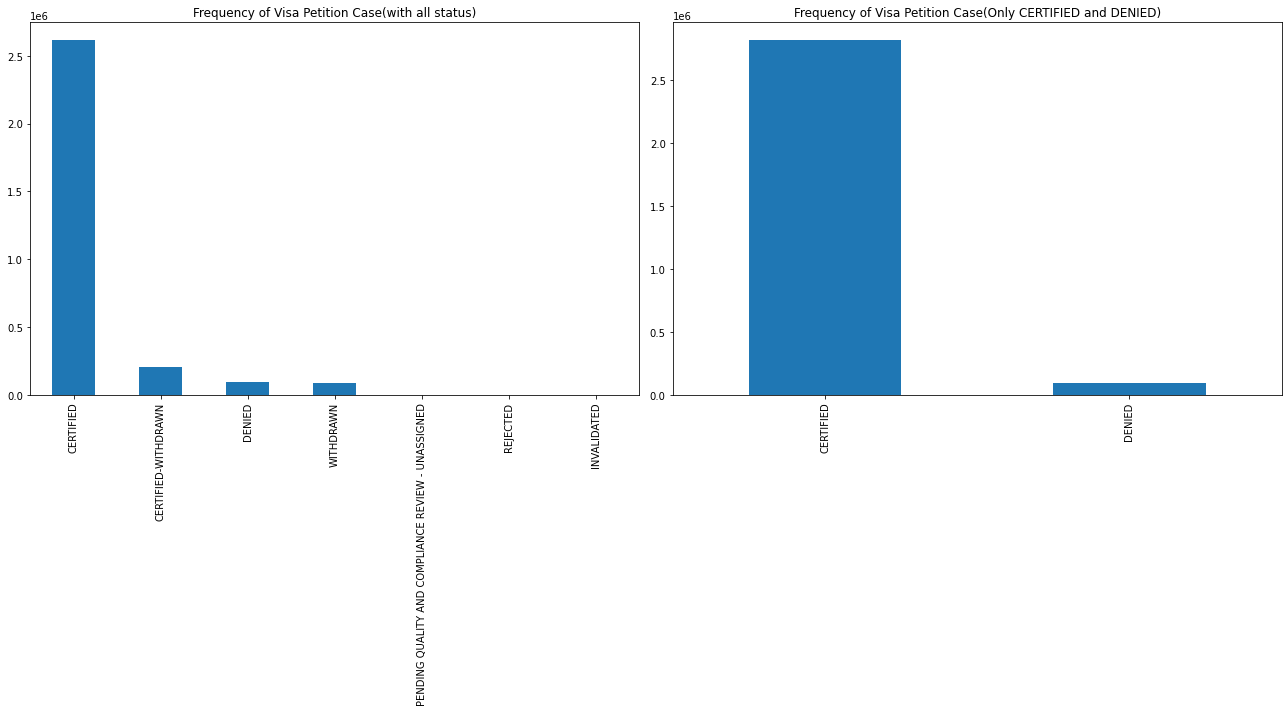

In [10]:
plt.figure(figsize=(18,10))
plt.subplot(1, 2, 1)
data['CASE_STATUS'].value_counts().plot(kind='bar',title='Frequency of Visa Petition Case(with all status)')
plt.subplot(1, 2, 2)
cdf['CASE_STATUS'].value_counts().plot(kind='bar',title='Frequency of Visa Petition Case(Only CERTIFIED and DENIED)')
plt.tight_layout()
plt.show()

##### EMPLOYER_NAME and SOC_NAME:
In EMPLOYER_NAME column, number of unique value is 234089 and top company is Infosys Limited. Top five companies that file the most visa petition case is IT related according to following bar chart.

The number of unique value for *SOC_NAME* is also huge. The chart below displays that *Computer Analysts* is the top most job position for which people are recruited.

In [11]:
print('Summary of EMPLOYER_NAME column: ',cdf['EMPLOYER_NAME'].describe())

Summary of EMPLOYER_NAME column:  count             2912628
unique             234089
top       INFOSYS LIMITED
freq               130317
Name: EMPLOYER_NAME, dtype: object


In [12]:
print('Summary of SOC_NAME column: : ',cdf['SOC_NAME'].describe())

Summary of SOC_NAME column: :  count                       2895573
unique                         2108
top       Computer Systems Analysts
freq                         284987
Name: SOC_NAME, dtype: object


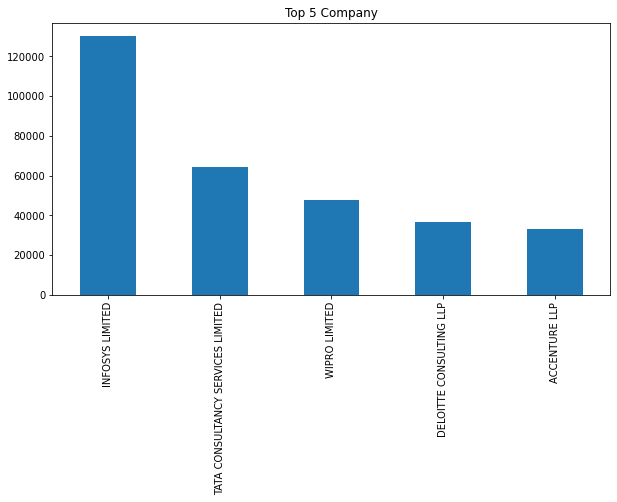

In [13]:
plt.figure(figsize=(10,5))
cdf.EMPLOYER_NAME.value_counts().head(5).plot(kind='bar',title='Top 5 Company')
plt.show()

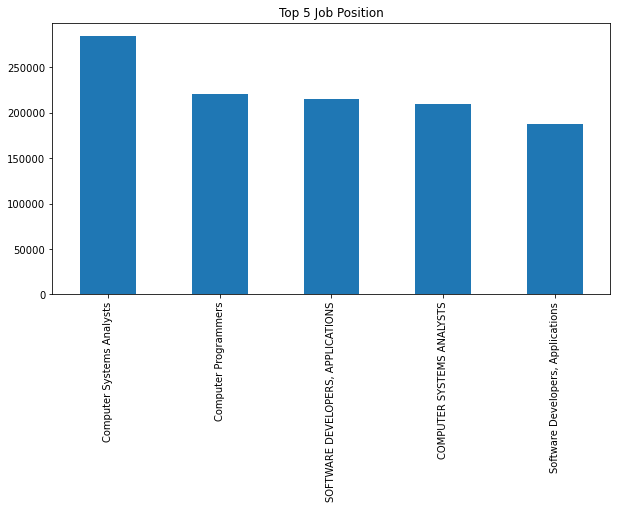

In [14]:
plt.figure(figsize=(10,5))
cdf.SOC_NAME.value_counts().head(5).plot(kind='bar',title='Top 5 Job Position')
plt.show()

##### PREVAILING_WAGE:
In PREVAILING_WAGE column, minimum salary is 0.0 where, maximum is 6000 million. Median value is 65000.0 but mean is 142891. It can be seen that there is extreme difference between the minimum and maximum value. So, it is clear that multiple outliers exist in the dataset. From the box plot of 500 rows of data, it shows the existence of outlier. Interestingly, in case_status vs wage plot, more outlier is identified in denial cases.

In [15]:
print('Median: ',np.nanmedian(cdf['PREVAILING_WAGE']))
print('Mean: ',np.nanmean(cdf['PREVAILING_WAGE']))
cdf.PREVAILING_WAGE.describe()

Median:  65000.0
Mean:  142891.0350401751


count    2.912593e+06
mean     1.428910e+05
std      5.282312e+06
min      0.000000e+00
25%      5.441300e+04
50%      6.500000e+04
75%      8.143200e+04
max      6.997607e+09
Name: PREVAILING_WAGE, dtype: float64

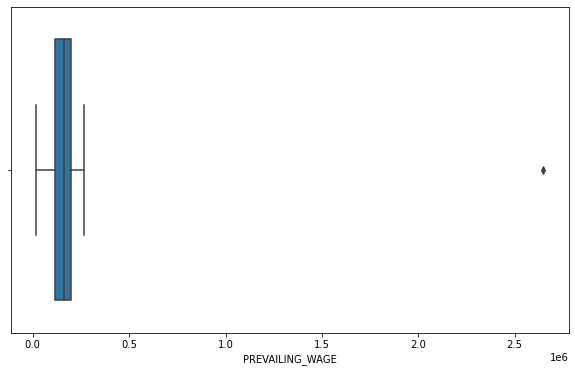

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data.PREVAILING_WAGE.head(500))
plt.show()

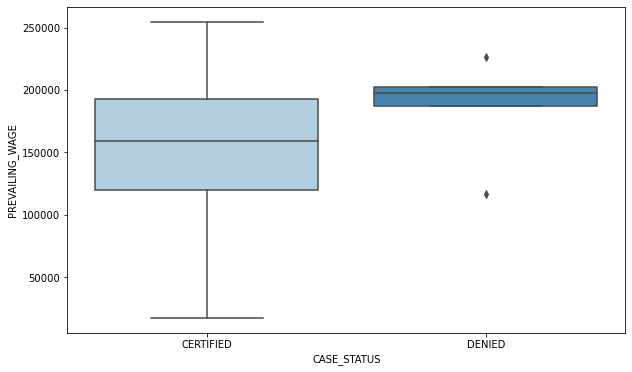

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x="CASE_STATUS", y="PREVAILING_WAGE", data=cdf.head(100),palette="Blues")
plt.show()

##### Year:
In following density plot, it shows the trend of wage pattern over the year from 2011-2016. All the patterns are right skewed and indicate a number of outliers.
Since here the visualization is not proper we will visualize the same in Tableau

(-100000.0, 300000000.0)

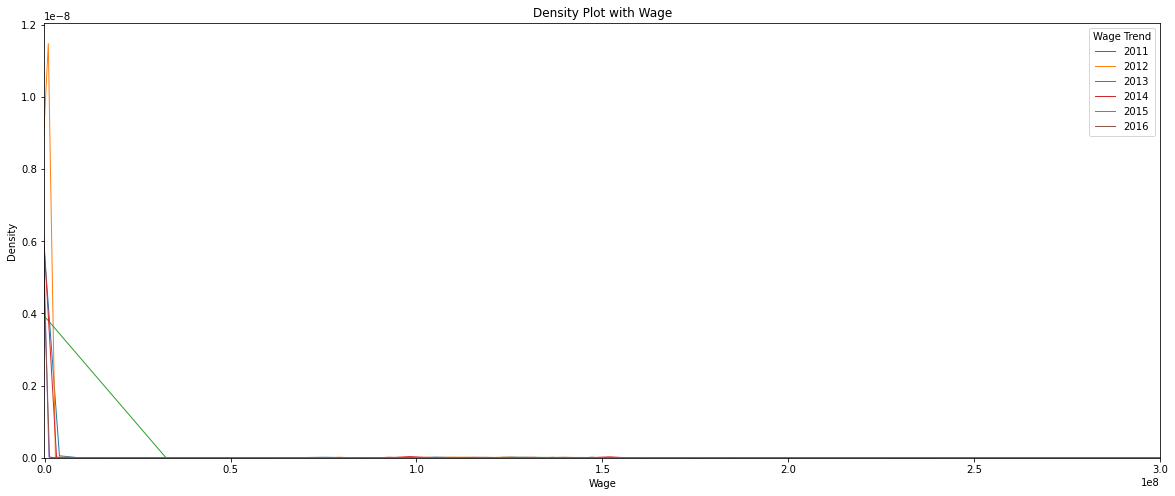

In [18]:
years = [2011,2012,2013,2014,2015,2016]

plt.figure(figsize=(20,8))
# Iterate through the five airlines
for year in years:
    # Subset to the airline
    subset = data[data['YEAR'] == year]
    # Draw the density plot
    sns.distplot(subset['PREVAILING_WAGE'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = year)

# Plot formatting
plt.legend(prop={'size': 10}, title = 'Wage Trend')
plt.title('Density Plot with Wage')
plt.xlabel('Wage')
plt.ylabel('Density')
plt.xlim(-100000,300000000)

##### WORKSITE: 
In this column, total unique city is 18189. New York is the top city from where most of the visa petition has been filed.

In [19]:
cdf.WORKSITE.describe()

count                2912659
unique                 18189
top       NEW YORK, NEW YORK
freq                  185817
Name: WORKSITE, dtype: object

<AxesSubplot:title={'center':'Top 5 City with Most Working Position'}>

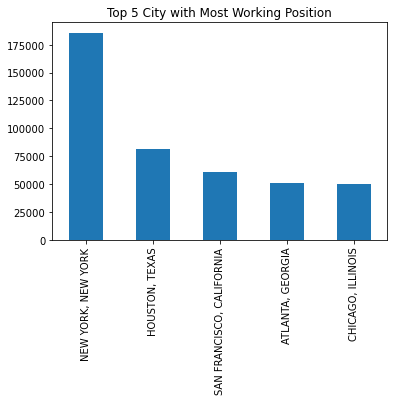

In [20]:
cdf.WORKSITE.value_counts().head(5).plot(kind='bar',title='Top 5 City with Most Working Position')

### Data Preprocessing

##### Missing Value Handling: 
From previous section, it is clear that lon and lat variable has the most missing values. These two variables indicate the location of employer. As we are going to use WORKSITE variable for this purpose, we will drop these columns. Moreover, JOB_TITLE and SOC_NAME are both indicated the job title which can be represented by any of these columns. That's why we have removed the JOB_TITLE column as well. After that, if there is any row with NAN value, we are going to drop them as well.

In [21]:
data['JOB_TITLE'].value_counts()

PROGRAMMER ANALYST                              249038
SOFTWARE ENGINEER                               121307
COMPUTER PROGRAMMER                              70570
SYSTEMS ANALYST                                  61965
SOFTWARE DEVELOPER                               42907
                                                 ...  
MANAGER-PRODUCTION/PROCESS MANAGER                   1
MANAGER (TECHNOLOGY)                                 1
ASSOCIATE PROJECT MANAGER-RELEASE MANAGEMENT         1
PROFESSIONAL DATA ANALYSIS                           1
SYSWTEMS ADMINISTRATOR                               1
Name: JOB_TITLE, Length: 287549, dtype: int64

In [22]:
data['SOC_NAME'].value_counts()

Computer Systems Analysts                          291170
Computer Programmers                               226574
SOFTWARE DEVELOPERS, APPLICATIONS                  221783
COMPUTER SYSTEMS ANALYSTS                          215353
Software Developers, Applications                  192933
                                                    ...  
ELEMENTARY SCHOOL TEACHERS, EXCEPT SPECIAL EDU          1
27-3031                                                 1
HEALTH PROFESSIONALS AND TECHNICIANS, ALL OTHER         1
15-1132                                                 1
Earth Drillers, Except Oil and Gas                      1
Name: SOC_NAME, Length: 2132, dtype: int64

In [23]:
#drop JOB_TITLE, lattitude and longitutde
cdf.drop('JOB_TITLE',inplace=True,axis=1)
cdf.drop('lon',inplace=True,axis=1)
cdf.drop('lat',inplace=True,axis=1)

In [24]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912659 entries, 1 to 3002458
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_STATUS         object 
 1   EMPLOYER_NAME       object 
 2   SOC_NAME            object 
 3   FULL_TIME_POSITION  object 
 4   PREVAILING_WAGE     float64
 5   YEAR                float64
 6   WORKSITE            object 
dtypes: float64(2), object(5)
memory usage: 177.8+ MB


In [25]:
cdf.isna().sum()

CASE_STATUS              13
EMPLOYER_NAME            31
SOC_NAME              17086
FULL_TIME_POSITION       14
PREVAILING_WAGE          66
YEAR                     13
WORKSITE                  0
dtype: int64

In [26]:
cdf.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
1,CERTIFIED,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN"
2,CERTIFIED,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,Y,242674.0,2016.0,"PLANO, TEXAS"
3,CERTIFIED,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY"
4,CERTIFIED,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,Y,220314.0,2016.0,"DENVER, COLORADO"
6,CERTIFIED,BURGER KING CORPORATION,CHIEF EXECUTIVES,Y,225000.0,2016.0,"MIAMI, FLORIDA"


In [27]:
from sklearn.impute import SimpleImputer

In [28]:
si_mean = SimpleImputer(strategy='mean') # for imputing with mean values for numerical columns
si_median = SimpleImputer(strategy='median') # for imputing columns with median values for numerical columns
si_mode = SimpleImputer(strategy='most_frequent') # for imputing columns with mode values for categorical columns

In [29]:
cdf['EMPLOYER_NAME'] = si_mode.fit_transform(cdf[['EMPLOYER_NAME']])
cdf['FULL_TIME_POSITION'] = si_mode.fit_transform(cdf[['FULL_TIME_POSITION']])
cdf['PREVAILING_WAGE'] = si_median.fit_transform(cdf[['PREVAILING_WAGE']])
cdf['YEAR'] = si_mean.fit_transform(cdf[['YEAR']])

In [30]:
cdf.isna().sum()

CASE_STATUS              13
EMPLOYER_NAME             0
SOC_NAME              17086
FULL_TIME_POSITION        0
PREVAILING_WAGE           0
YEAR                      0
WORKSITE                  0
dtype: int64

Dropping those rows which contans missing values from SOC_NAME & Case Status Column

In [31]:
cdf.dropna(inplace=True)

Imbalanced Class: 
In this dataset, the target(CASE_STATUS) variable have 2818282 Certified and 94364 Denied cases which makes this dataset highly imbalanced. It can influence the classification task. To make it balance, I have downsampled the Certified cases to the count of the Denied cases.

In [32]:
cdf['CASE_STATUS'].value_counts()

CERTIFIED    2801733
DENIED         93840
Name: CASE_STATUS, dtype: int64

In [33]:
# Down sampling
class_certified, class_denied = cdf.CASE_STATUS.value_counts()
# Divide by class
cdf_class_c = cdf[cdf.CASE_STATUS=='CERTIFIED']
cdf_class_d = cdf[cdf.CASE_STATUS=='DENIED']

cdf_class_c_under =cdf_class_c.sample(class_denied,random_state=1234563)
cdf_down = pd.concat([cdf_class_c_under, cdf_class_d], axis=0)

print('Random under-sampling:')
print(cdf_down.CASE_STATUS.value_counts())

Random under-sampling:
CERTIFIED    93840
DENIED       93840
Name: CASE_STATUS, dtype: int64


Advantages of Undersampling:

Reduced Training Time: By reducing the number of majority class samples, undersampling can lead to faster training times, as the model processes a smaller amount of data.

Mitigation of Overfitting: Undersampling can help prevent the model from overfitting to the majority class, as it is exposed to a more balanced representation of both classes.

Improved Model Interpretability: With a balanced dataset, the model may have an easier time learning the patterns of the minority class, which can lead to improved interpretability of the model's decisions.

Elimination of Noise: In some cases, the majority class may contain noisy or irrelevant samples. Undersampling can help in removing such noise, leading to a more focused and accurate model.

Disadvantages of Undersampling:

Loss of Information: Undersampling involves removing samples from the majority class, potentially leading to the loss of valuable information that could aid in training a more robust model.

Risk of Bias: If the majority class samples that are removed during undersampling contain important information, the model might become biased towards the minority class and perform poorly on the majority class.

Reduced Representativeness: With fewer majority class samples, the training data might not be as representative of the true data distribution, leading to poorer generalization to unseen data.

Increased Variance: A smaller dataset due to undersampling can increase the variance of the model's performance, making it more sensitive to fluctuations in the data.

Possibility of Underfitting: If the dataset becomes too unrepresentative of the original distribution, the model might struggle to capture the underlying patterns of both classes, leading to underfitting.

Loss of Context: The relationships between the majority and minority classes might be important for accurate classification. Undersampling can reduce the context in which the minority class operates.

Dependency on Sampling Strategy: The effectiveness of undersampling can vary based on the specific strategy used (e.g., random undersampling, cluster-based undersampling). Choosing the right strategy is crucial for achieving good results.

Data Scarcity: In cases where the dataset is already small or lacks sufficient samples, further reducing the dataset size through undersampling can exacerbate the problem.

In summary, undersampling can be a useful approach to handle class imbalance in certain situations, especially when the majority class contains noise or when computational resources are limited. However, it comes with significant trade-offs in terms of information loss and potential bias. Careful consideration of the dataset, the characteristics of the classes, and the desired outcomes is essential when deciding whether to use undersampling or to combine it with other techniques like oversampling or generating synthetic samples.

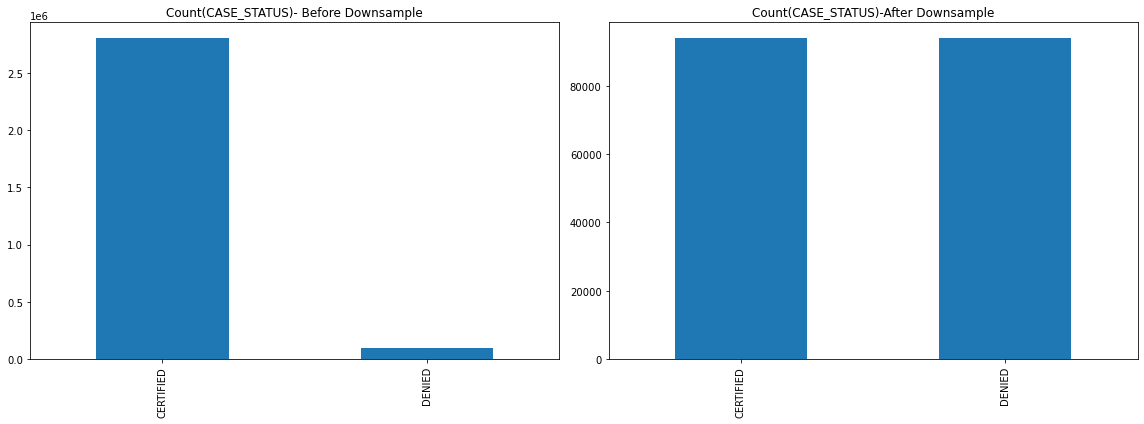

In [34]:
#Graph before after down sampling
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
cdf['CASE_STATUS'].value_counts().plot(kind='bar', title='Count(CASE_STATUS)- Before Downsample');
plt.subplot(1, 2, 2)
cdf_down.CASE_STATUS.value_counts().plot(kind='bar', title='Count(CASE_STATUS)-After Downsample');
plt.tight_layout()
plt.show()

Outlier: We have checked PREVAILING_WAGE if there was any outliers affecting the dataset. In most of the cases, petitions have a wage in the range between 40k and 80k US Dollars. There are certain petitions with wages of more than 500k, and some with 0 dollars. Since these are very extreme cases, they should be treated as outliers. We have used IQR test to find the outlier that is if data point is above the third quartile or below the first quartile it should be removed. Finally, We have replaced the NA value with mean.

In [35]:
## Feature: Wage
#detect outlier in PREVAILING_WAGE
q1 = cdf_down["PREVAILING_WAGE"].quantile(0.25)
q3 = cdf_down["PREVAILING_WAGE"].quantile(0.75)
IQR = q3 - q1
outliers = ((cdf_down["PREVAILING_WAGE"] < (q1 - 1.5 * IQR)) | (cdf_down["PREVAILING_WAGE"] > (q3 + 1.5 * IQR))).sum()
print(f'Lower Whisker : {q1 - 1.5*IQR}')
print(f'Upper Whisker : {q3 + 1.5*IQR}')
print('No of outliers: ', outliers)

Lower Whisker : 5825.0
Upper Whisker : 124633.0
No of outliers:  9676


In [36]:
cdf_down[cdf_down['PREVAILING_WAGE'] < (q1 - 1.5*IQR)].index
cdf_down[cdf_down['PREVAILING_WAGE'] > (q3 + 1.5*IQR)].index

Int64Index([1294975,  373090, 1641446, 1338669, 1661392,  893394, 1854107,
             784675,  719755,  389023,
            ...
            3001379, 3001517, 3001847, 3002102, 3002152, 3002212, 3002306,
            3002310, 3002313, 3002340],
           dtype='int64', length=9639)

In [37]:
# drop outlier
cdf_down = cdf_down.drop(cdf_down[cdf_down.PREVAILING_WAGE < (q1 - 1.5 * IQR)].index)
cdf_down = cdf_down.drop(cdf_down[cdf_down.PREVAILING_WAGE > (q1 + 1.5 * IQR)].index)

After capping the wages with second quartile and third quartile, the mean and median are very similar. The following density plot shows a better distribution of data than without outlier.

<Figure size 1296x720 with 0 Axes>

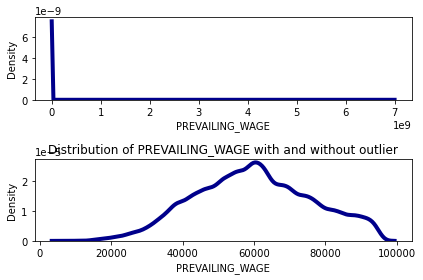

In [38]:
# plot density of PREVAILING_WAGE
plt.figure(figsize=(18,10))
fig, ax =plt.subplots(2,1)
plt.title('Distribution of PREVAILING_WAGE with and without outlier')
sns.distplot(cdf['PREVAILING_WAGE'], hist=False,kde=True,color='darkblue',kde_kws={'linewidth':4},ax=ax[0])
sns.distplot(cdf_down['PREVAILING_WAGE'], hist=False,kde=True,color='darkblue',kde_kws={'linewidth':4},ax=ax[1])
plt.tight_layout()
fig.show()

In [39]:
cdf_down['CASE_STATUS'].value_counts()
# after removing outliers these are the counts of certified and denied cases

CERTIFIED    81105
DENIED       80288
Name: CASE_STATUS, dtype: int64

In [40]:
cdf_down['PREVAILING_WAGE'].describe()

count    161393.000000
mean      59894.744724
std       16331.834885
min        7799.000000
25%       48131.000000
50%       59634.000000
75%       71300.000000
max       94931.000000
Name: PREVAILING_WAGE, dtype: float64

In [41]:
cdf_down.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161393 entries, 790904 to 3002393
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CASE_STATUS         161393 non-null  object 
 1   EMPLOYER_NAME       161393 non-null  object 
 2   SOC_NAME            161393 non-null  object 
 3   FULL_TIME_POSITION  161393 non-null  object 
 4   PREVAILING_WAGE     161393 non-null  float64
 5   YEAR                161393 non-null  float64
 6   WORKSITE            161393 non-null  object 
dtypes: float64(2), object(5)
memory usage: 9.9+ MB


In [42]:
# adding a new column date column which consists of
cdf_down['DATE'] = cdf_down['YEAR'].astype('int')
cdf_down['DATE'] = pd.to_datetime(cdf_down['DATE'],yearfirst=True,format="%Y")

In [43]:
cdf_down.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,DATE
790904,CERTIFIED,STATE FARM MUTUAL AUTOMOBILE INSURANCE COMPANY,COMPUTER SYSTEMS ANALYSTS,Y,76586.0,2015.0,"BLOOMINGTON, ILLINOIS",2015-01-01
1373320,CERTIFIED,"XENOSOFT TECHNOLOGIES, INC",Computer Programmers,Y,58011.0,2014.0,"MUSCATINE, IOWA",2014-01-01
2858579,CERTIFIED,VIDEOMINING CORPORATION,"Computer Software Engineers, Applications",Y,73590.0,2011.0,"STATE COLLEGE, PENNSYLVANIA",2011-01-01
1095251,CERTIFIED,"SMARTINSIGHT, LLC","SOFTWARE DEVELOPERS, APPLICATIONS",Y,71802.0,2015.0,"QUINCY, MASSACHUSETTS",2015-01-01
1926007,CERTIFIED,INFOSYS LIMITED,Computer Programmers,Y,70948.8,2013.0,"SAN FRANCISCO, CALIFORNIA",2013-01-01


##### Data Cleaning and Filtering:

In EMPLOYER_NAME column, there are lot of unique employers. We removed the special characters and lowercase the name to uniform the format and enforce consistency. Inspite of that, it has got more than 500 categories. So we removed those employees name who filed less than 4 applications.

In [44]:
cdf_down.EMPLOYER_NAME = cdf_down.EMPLOYER_NAME.str.lower()
emp_name = {
   'EMPLOYER_NAME': {
      r"[.\-,);\"'(+/]|(&QUOT;)":'',
      r'ltd':'limited',
      r'(&amp;)|&':'and',
      r'(.*gates corporation.*$)':'gates corporation',
      r'corp$':'corporation',
      r'^europeanamerican':'european american',
      r'(.*euromarket designs inc.*$)':'euro market designs inc',
      r'(.*eurofins lancaster laboratories*$)':'eurofins lancaster laboratories inc',
      r'^eurocolletion|^eurocollection':'euro collection',
      r'^technosoft':'techno soft',
      r'^healthcare':'health care',
      r'^healthplan':'health plan',
      r'warner university inc':'warner university',
      r'grouppc$':'group pc',
      r'americasinc$':'americas inc'}
}
cdf_down.replace(emp_name, regex=True, inplace=True)

In [45]:
cdf_down['CASE_STATUS'].value_counts()

CERTIFIED    81105
DENIED       80288
Name: CASE_STATUS, dtype: int64

In [46]:
cdf_dict = cdf_down.EMPLOYER_NAME.value_counts().to_dict()
cdf_dict

{'infosys limited': 4389,
 'tata consultancy services limited': 2238,
 'wipro limited': 1649,
 'deloitte consulting llp': 1547,
 'ibm india private limited': 1407,
 'accenture llp': 1138,
 'ernst and young us llp': 869,
 'hcl america inc': 766,
 'cognizant technology solutions us corporation': 756,
 'capgemini america inc': 581,
 'microsoft corporation': 565,
 'igate technologies inc': 543,
 'larsen and toubro infotech limited': 530,
 'ust global inc': 464,
 'ibm corporation': 452,
 'deloitte and touche llp': 451,
 'tech mahindra americasinc': 383,
 'fujitsu america inc': 339,
 'tech mahindra americas inc': 338,
 'intel corporation': 336,
 'satyam computer services limited': 252,
 'amazon corporate llc': 239,
 'google inc': 237,
 'mphasis corporation': 235,
 'hexaware technologies inc': 216,
 'pricewaterhousecoopers llp': 215,
 'jpmorgan chase and co': 211,
 'mastech inc a mastech holdings inc company': 194,
 'qualcomm technologies inc': 187,
 'oracle america inc': 184,
 'kpmg llp': 18

In [47]:
#Remove rows of the employers with less than 4 application
cdf_dict = cdf_down.EMPLOYER_NAME.value_counts().to_dict()
emp_list = [k for k,v in cdf_dict.items() if v<=5]
len(emp_list)
cdf_down = cdf_down[~cdf_down.EMPLOYER_NAME.isin(emp_list)]

In [48]:
cdf_down['CASE_STATUS'].value_counts()

CERTIFIED    55761
DENIED       23821
Name: CASE_STATUS, dtype: int64

In [49]:
cdf_down['EMPLOYER_NAME'].value_counts().count()

3485

There are also many unique values in *SOC_NAME* column. We did the same special characters removal as *EMPLOYER_NAME*. We have created a dictionary to find out the data that are belonged to specific occupation section. We have created 13 categories for this purpose. Then put the values in **Other** category that have application number less than 5.

In [50]:
# Feature 3: SOC_NAME
#remove special characters to uniform format
cdf_down['SOC_NAME']=cdf_down['SOC_NAME'].str.lower()
soc = {
   'SOC_NAME': {
      r"[*.\-,);\"'(+/]|<font>|</font>|(^[0-9]$)":'',
      r'&amp|&':' and ',
      r'^compute|^computer|^copmuter|^computers|^comuter|^compuer':'computer',
      r'induatrial':'industrial',
      r'engineers|enginers|engineering|engineerarquitects|enigneers|engineerarchitect':'engineer',
      r'analysta|analystt|analyhsts|analys$|anlysts':'analyst',
      r'sofware|softare|softwware':'software',
      r'^all other|all other$|other$|all othter$':'',
      r'systemanalyst':'system analyst',
      r'hardward':'hardware',
      r'aplications|applications|appllications|applicationsssss':'application',
      r'dvelopers|developers|developpers': 'developer',
      r'datebase':'database',
      r'maanger|mangers|managerse|managers':'manager',
      r'sysems|systems':'system',
      r'technicans|technicians':'technician',
      r'deisgners|designers':'designer',
      r'operations':'operation',
      r'except computer non|except computer|except compuer':'',
      r'software application developer|application developer':'software developer application'}
}

cdf_down.replace(soc, regex=True, inplace=True)
cdf_down=cdf_down[~cdf_down['SOC_NAME'].str.contains('^[0-9]*$',na=False)]

In [51]:
#Create dictionary to put the different job title in specific profession section
job_sector = {
   'SOC_NAME': {
      r".*agricultural(?s).*|.*maids(?s).*|.*cleaner(?s).*|.*bakers(?s).*|.*bartenders(?s).*|.*chefs(?s).*|.*butchers(?s).*|.*meat(?s).*|dishwashers|^laundry(?s).*|^funeral(?s).*|.*janitor(?s).*|^housekeeping(?s).*|^cook(?s).*|.*food(?s).*":'Food & Service',
      r'^computer(?s).*|^information security(?s).*|^web developer(?s).*|^database(?s).*|^data warehousing(?s).*|^graphic(?s).*|^network and computer(?s).*|.*network system(?s).*|^software(?s).*|^information technology(?s).*':'IT Profession',
      r".*mathematician(?s).*|.*statisticians(?s).*|statistican|biostatisticians":'Mathematician',
      r'.*survey(?s).*|.*school(?s).*|.*secondary school(?s).*|.*elementary school(?s).*|.*teachers(?s).*|.*postsecondary(?s).*|.*educators(?s).*|.*research assistants(?s).*|.*education(?s).*|.*translators(?s).*|.*training(?s).*|.*instructors(?s).*|.*instructional coordinators(?s).*':'Teaching',
      r'.*physician assistants(?s).*|.*orthodontists(?s).*|.*optometrists(?s).*|.*epidemiologists(?s).*|.*anesthesiologists(?s).*|.*rehabilitation(?s).*|.*dietitians(?s).*|.*nutritionists(?s).*|.*gynecologists(?s).*|.*mental(?s).*|.*health(?s).*|^biochemists(?s).*|^healthcare(?s).*|^health diagnosing(?s).*|.*pediatricians(?s).*|.*surgeons(?s).*|.*physical(?s).*|physicists|.*medical(?s).*|.*nurses(?s).*|.*pathologists(?s).*|.*practitioners$|.*psychiatrists(?s).*|veterinarians|pharmacists|^radiologists(?s).*|.*therapists(?s).*|neurologists|.*dentists(?s).*':'Medical',
      r'.*loan(?s).*|.*property(?s).*|.*credit analysts(?s).*|.*financial(?s).*|^budget(?s).*|.*bill(?s).*|.*account(?s).*|.*accountants(?s).*|economists|^cost(?s).*|^statistical assistants(?s).*|^business operation specialists(?s).*|.*fiancial(?s).*':'Finance',
      r'.*aircraft(?s).*|.*operating engineer(?s).*|.*structural(?s).*|.*engineer(?s).*|.*electrical(?s).*|.*electronics(?s).*|.*designer(?s).*|.*architect(?s).*':'Architecture & Engineering',
      r'.*biologist(?s).*|.*astronomers(?s).*|.*microbiologists(?s).*|.*biophysicist(?s).*|.*scienctists(?s).*|.*scientists(?s).*|chemists|^biological scientists $|^biomedical(?s).*':'Advance Science',
      r'.*manager(?s).*|operations research analysts|.*management(?s).*|chief executives|public relations specialists|logisticians|administrative services manager|.*planners(?s).*|human resources specialists|lodging manager|engineer manager':'Management',
      r'.*market(?s).*|.*marketing(?s).*|.*wholesale(?s).*|^sales(?s).*|^advertising(?s).*|compliance officers|.*salespersons$':'Marketing',
      r'.*judicial(?s).*|.*police(?s).*|.*law(?s).*|lawyers|.*judges(?s).*|.*attorney(?s).*|.*paralegals(?s).*|.*legal(?s).*':'Lawyer',
      r'.*technician(?s).*|.*operators(?s).*|.*technologists(?s).*':'Technician',
      r'.*audio(?s).*|.*photo(?s).*|.*recreation(?s).*|.*artists(?s).*|.*auditors(?s).*|.*athletic(?s).*|.*video(?s).*|.*writers(?s).*|.*music(?s).*|.*models(?s).*|composers|.*media(?s).*|singers|.*dancers(?s).*|poets and lyricists|coaches and scouts|.*sport(?s).*|.*fashion(?s).*|^media and communication workers$|^multimedia artists and animators|editors|^set designer$|^producers and directors$|^art directors$|^designer$|^reporters and correspondents$|.*entertainment(?s).*':'Fashion & Entertainment',
   }
}
cdf_down.replace(job_sector, regex=True, inplace=True)

In [52]:
cdf_dict=cdf_down['SOC_NAME'].value_counts().to_dict()
soc_list = [k for k,v in cdf_dict.items() if v<=5]
len(soc_list)
cdf_down.SOC_NAME = np.where(cdf_down['SOC_NAME'].isin(soc_list), 'Others', cdf_down.SOC_NAME)

In [53]:
cdf_down['CASE_STATUS'].value_counts()

CERTIFIED    55761
DENIED       23821
Name: CASE_STATUS, dtype: int64

In [54]:
cdf_down['SOC_NAME'].value_counts().count()

41

WORKSITE represents employee’s intended area of employment. We split this column and consider city name only.

In [55]:
cdf_down['WORKSITE']

1373320              MUSCATINE, IOWA
1926007    SAN FRANCISCO, CALIFORNIA
1601710               COLUMBUS, OHIO
2417561             CONWAY, ARKANSAS
2420331        EAST PEORIA, ILLINOIS
                     ...            
3002354             CINCINNATI, OHIO
3002355            BEAVERTON, OREGON
3002357               HOUSTON, TEXAS
3002365       SANTA CRUZ, CALIFORNIA
3002368             PORTLAND, OREGON
Name: WORKSITE, Length: 79582, dtype: object

In [56]:
# Feature 8: WORKSITE
#select state as employer location
cdf_down['WORKSITE']=cdf_down['WORKSITE'].str.split(',',1).str[1].str.lower()

In [57]:
cdf_down.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,DATE
1373320,CERTIFIED,xenosoft technologies inc,IT Profession,Y,58011.0,2014.0,iowa,2014-01-01
1926007,CERTIFIED,infosys limited,IT Profession,Y,70948.8,2013.0,california,2013-01-01
1601710,CERTIFIED,tata consultancy services limited,IT Profession,Y,41558.0,2014.0,ohio,2014-01-01
2417561,CERTIFIED,acxiom corporation,IT Profession,Y,47570.0,2012.0,arkansas,2012-01-01
2420331,CERTIFIED,automotive robotics inc,Architecture & Engineering,Y,55598.0,2012.0,illinois,2012-01-01


In [58]:
def space_remover(x):
  x = x.replace(' ','')
  return x

In [59]:
cdf_down['WORKSITE'] = cdf_down['WORKSITE'].apply(space_remover)

In [60]:
cdf_down['WORKSITE'].value_counts()

california            11173
texas                  8256
newjersey              6235
newyork                6094
illinois               4739
pennsylvania           3608
massachusetts          3361
georgia                3149
virginia               2555
michigan               2521
washington             2519
northcarolina          2499
florida                2460
ohio                   2458
minnesota              1539
maryland               1469
connecticut            1417
arizona                1243
missouri               1124
wisconsin              1029
colorado                919
indiana                 884
tennessee               860
oregon                  681
delaware                646
districtofcolumbia      576
iowa                    502
arkansas                447
kansas                  424
rhodeisland             372
kentucky                357
utah                    349
southcarolina           334
alabama                 288
newhampshire            279
louisiana           

In [61]:
cdf_down['CASE_STATUS'].value_counts()

CERTIFIED    55761
DENIED       23821
Name: CASE_STATUS, dtype: int64

In [62]:
cdf_down.columns

Index(['CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'FULL_TIME_POSITION',
       'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'DATE'],
      dtype='object')

In [64]:
# we will use over sampling after converting categorical to numerical and after scaling since it requires data in numeric form
'''
from imblearn.over_sampling import SMOTE
from collections import Counter

X = cdf_down[['EMPLOYER_NAME', 'SOC_NAME', 'FULL_TIME_POSITION','PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'Date']]
y = cdf_down['CASE_STATUS']

# Print the original class distribution
print("Original class distribution:", Counter(y))

# Instantiate the SMOTE algorithm
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print the resampled class distribution
print("Resampled class distribution:", Counter(y_resampled))
'''

'\nfrom imblearn.over_sampling import SMOTE\nfrom collections import Counter\n\nX = cdf_down[[\'EMPLOYER_NAME\', \'SOC_NAME\', \'FULL_TIME_POSITION\',\'PREVAILING_WAGE\', \'YEAR\', \'WORKSITE\', \'Date\']]\ny = cdf_down[\'CASE_STATUS\']\n\n# Print the original class distribution\nprint("Original class distribution:", Counter(y))\n\n# Instantiate the SMOTE algorithm\nsmote = SMOTE(sampling_strategy=\'auto\', random_state=42)\n\n# Apply SMOTE to generate synthetic samples\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\n# Print the resampled class distribution\nprint("Resampled class distribution:", Counter(y_resampled))\n'

#### Advantages of SMOTE:

Improved Model Performance: SMOTE generates synthetic samples that can help the model learn the characteristics of the minority class more effectively. This can lead to improved generalization and better performance on unseen data.

Reduced Overfitting: By creating synthetic samples, SMOTE reduces the risk of overfitting to the majority class, allowing the model to better capture the underlying patterns of the data.

Preservation of Information: SMOTE generates synthetic samples by interpolating between real samples, ensuring that the generated data points are representative of the true data distribution and preserve the inherent information of the minority class.

Expanded Decision Boundary: The introduction of synthetic samples can lead to a more expanded and better-defined decision boundary between classes, resulting in better class separation.

Mitigated Bias: SMOTE reduces the bias towards the majority class, allowing the model to pay more attention to the minority class during training.

Compatibility with Various Algorithms: SMOTE can be used in conjunction with a variety of machine learning algorithms, making it versatile and easy to integrate into different modeling approaches.

Data Augmentation: SMOTE effectively augments the dataset for the minority class, which can be particularly useful when obtaining more real-world data is challenging.

Disadvantages of SMOTE:

Risk of Overfitting: While SMOTE helps in mitigating overfitting to the majority class, it might lead to overfitting to the synthetic samples themselves if not used cautiously.

Potential for Noise: In some cases, SMOTE might generate noisy samples that do not accurately represent the true distribution of the minority class.

Increased Computational Complexity: Generating synthetic samples through SMOTE requires extra computational resources, and the increased dataset size can lead to longer training times.

Dependency on Nearest Neighbors: SMOTE relies on the nearest neighbors of existing samples to generate synthetic samples. If the nearest neighbors are not well-representative of the true data distribution, the generated samples may not be accurate.

Sensitive to Hyperparameters: The effectiveness of SMOTE can depend on hyperparameters such as the number of synthetic samples generated and the choice of nearest neighbors. These need to be carefully tuned for optimal results.

Limited to Feature Space: SMOTE operates in the feature space and may not capture more complex relationships that exist in the input data.

Imbalanced Neighborhoods: In cases where the minority class is very sparse and scattered, it might be challenging to find suitable neighbors for generating synthetic samples.

In summary, while SMOTE offers several benefits for handling class imbalance, it's not a one-size-fits-all solution. Careful consideration of its advantages and disadvantages, along with experimentation and tuning, is crucial to determine its appropriateness for a given dataset and problem. Additionally, there are variations and improvements on the basic SMOTE algorithm that aim to address some of its limitations.

##### Convert Categorical Data: 

These are the columns we now have in our dataset:

Ordinal Numeircal Values
  PREVAILING_WAGE

Nominal Values:
  CASE_STATUS
  FULL_TIME_POSITION
  EMPLOYER_NAME
  WORKSITE

As *PREVAILING_WAGE* has huge number of unique values, We will do Scaling for this column

The conversion of other colums are shown in the table below:

      |       Column       |       Conversion      |
      |:------------------:|:---------------------:|
      |     CASE_STATUS    | CERTIFIED=1, DENIED=0 |
      | FULL_TIME_POSITION |        Y=1, N=0       |
      |    EMPLOYER_NAME   |          OHE          |
      |      WORKSITE      |          OHE          |
As four columns of dataset are in object format, we have changed them into category type to fit into the model.

In [65]:
# Genereting new column related to prevailing wage into 'low', 'medium' and 'high'
def wage_categorizer(x):
    if x > 0 and x <= 30000:
        return 'LOW'
    elif x <= 60000:
        return 'MEDIUM'
    elif x > 60000:
        return 'HIGH'    

In [66]:
cdf_down['WAGE_CATERGORIZED'] = cdf_down['PREVAILING_WAGE'].apply(wage_categorizer)

In [67]:
cdf_down.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,DATE,WAGE_CATERGORIZED
1373320,CERTIFIED,xenosoft technologies inc,IT Profession,Y,58011.0,2014.0,iowa,2014-01-01,MEDIUM
1926007,CERTIFIED,infosys limited,IT Profession,Y,70948.8,2013.0,california,2013-01-01,HIGH
1601710,CERTIFIED,tata consultancy services limited,IT Profession,Y,41558.0,2014.0,ohio,2014-01-01,MEDIUM
2417561,CERTIFIED,acxiom corporation,IT Profession,Y,47570.0,2012.0,arkansas,2012-01-01,MEDIUM
2420331,CERTIFIED,automotive robotics inc,Architecture & Engineering,Y,55598.0,2012.0,illinois,2012-01-01,MEDIUM


In [68]:
cdf_down['WAGE_CATERGORIZED'].value_counts()

HIGH      46280
MEDIUM    32582
LOW         720
Name: WAGE_CATERGORIZED, dtype: int64

In [69]:
# Lets Export this to excel format for visualization in tableau and using it for model making
cdf_down.to_csv('h1b_for_model_making_02')